# **Traffic Jam Prediction Using LSTM**

**Dataset: Waze Open Data of Traffic Incidents**

Project By: Vivin T 

Import the necessary Libraries

In [56]:
import pandas as pd
import pickle
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM

Setting Data Path

In [57]:
data_dir = Path("/content")

Loading the Dataset

In [58]:
with open(data_dir / 'data.pickle', 'rb') as f:
    [event_dict, df] = pickle.load(f)

Printing the events

In [59]:
event_dict

{1: 'road closed due to construction',
 2: 'traffic jam',
 3: 'stopped car on the shoulder',
 4: 'road closed',
 5: 'other',
 6: 'object on roadway',
 7: 'major event',
 8: 'pothole',
 9: 'traffic heavier than normal',
 10: 'road construction',
 11: 'fog',
 12: 'accident',
 13: 'slowdown',
 14: 'stopped car',
 15: 'small traffic jam',
 16: 'stopped traffic',
 17: 'heavy traffic',
 18: 'minor accident',
 19: 'medium traffic jam',
 20: 'malfunctioning traffic light',
 21: 'missing sign on the shoulder',
 22: 'animal on the shoulder',
 23: 'animal struck',
 24: 'large traffic jam',
 25: 'hazard on the shoulder',
 26: 'hazard on road',
 27: 'ice on roadway',
 28: 'weather hazard',
 29: 'flooding',
 30: 'road closed due to hazard',
 31: 'hail',
 32: 'huge traffic jam'}

In [60]:
df.head(10)

,label,events
0,1,"[traffic heavier than normal, heavy traffic, m..."
1,1,"[traffic jam, road construction, stopped car o..."
2,1,[traffic jam]
3,1,[traffic jam]
4,1,"[traffic jam, traffic jam, traffic jam, traffi..."
5,1,"[stopped car on the shoulder, traffic jam, hea..."
6,1,"[stopped car on the shoulder, traffic jam, hea..."
7,1,"[traffic jam, small traffic jam, traffic jam, ..."
8,1,"[heavy traffic, traffic jam, traffic jam, stop..."
9,1,"[heavy traffic, traffic jam, traffic jam, stop..."


In [61]:
df.tail(10)

,label,events
851,0,"[traffic jam, traffic jam, traffic jam]"
852,0,"[stopped traffic, traffic jam, stopped traffic]"
853,0,"[stopped car on the shoulder, stopped traffic,..."
854,0,[stopped traffic]
855,0,"[stopped car on the shoulder, stopped car on t..."
856,0,"[heavy traffic, heavy traffic, heavy traffic, ..."
857,0,"[traffic jam, traffic jam]"
858,0,"[traffic jam, traffic jam, traffic heavier tha..."
859,0,"[heavy traffic, stopped car on the shoulder, t..."
860,0,"[heavy traffic, stopped car on the shoulder, s..."


Getting the index of the largest value

In [62]:
max_len_event_id = df.events.apply(len).idxmax()
max_len_event_id

105

Printing the row with the longest sequence


In [63]:
max_len_event = df.iloc[max_len_event_id]
max_len_event.events

['stopped car on the shoulder',
 'heavy traffic',
 'heavy traffic',
 'heavy traffic',
 'slowdown',
 'stopped traffic',
 'heavy traffic',
 'heavy traffic',
 'heavy traffic',
 'heavy traffic',
 'traffic heavier than normal',
 'stopped car on the shoulder',
 'traffic jam',
 'heavy traffic',
 'stopped traffic',
 'stopped traffic',
 'stopped traffic',
 'heavy traffic',
 'traffic jam',
 'stopped car on the shoulder',
 'stopped traffic',
 'stopped traffic',
 'stopped traffic',
 'heavy traffic',
 'traffic heavier than normal',
 'traffic heavier than normal',
 'traffic heavier than normal',
 'traffic heavier than normal',
 'heavy traffic',
 'stopped traffic',
 'traffic heavier than normal',
 'pothole',
 'stopped car on the shoulder',
 'traffic jam',
 'slowdown',
 'stopped traffic',
 'heavy traffic',
 'traffic heavier than normal',
 'traffic jam',
 'traffic jam',
 'stopped car on the shoulder',
 'major event',
 'traffic jam',
 'traffic jam',
 'stopped traffic',
 'heavy traffic',
 'traffic heavie

**Printing the length of the longest row**


In [64]:
maxlen = len(max_len_event.events)
maxlen

84

Converting the "index:event" format into "event:index" format

In [65]:
reversed_dict = {}
for k, v in event_dict.items():
  reversed_dict[v] = k

In [66]:
reversed_dict

{'accident': 12,
 'animal on the shoulder': 22,
 'animal struck': 23,
 'flooding': 29,
 'fog': 11,
 'hail': 31,
 'hazard on road': 26,
 'hazard on the shoulder': 25,
 'heavy traffic': 17,
 'huge traffic jam': 32,
 'ice on roadway': 27,
 'large traffic jam': 24,
 'major event': 7,
 'malfunctioning traffic light': 20,
 'medium traffic jam': 19,
 'minor accident': 18,
 'missing sign on the shoulder': 21,
 'object on roadway': 6,
 'other': 5,
 'pothole': 8,
 'road closed': 4,
 'road closed due to construction': 1,
 'road closed due to hazard': 30,
 'road construction': 10,
 'slowdown': 13,
 'small traffic jam': 15,
 'stopped car': 14,
 'stopped car on the shoulder': 3,
 'stopped traffic': 16,
 'traffic heavier than normal': 9,
 'traffic jam': 2,
 'weather hazard': 28}

Converting List of Events into List of Numbers 

In [67]:
def map_event_list_to_idxs(event_list):
  list_idxs = []
  for event in (event_list):
    idx = reversed_dict[event]
    list_idxs.append(idx)
  return list_idxs

In [68]:
map_event_list_to_idxs(max_len_event.events)

[3,
 17,
 17,
 17,
 13,
 16,
 17,
 17,
 17,
 17,
 9,
 3,
 2,
 17,
 16,
 16,
 16,
 17,
 2,
 3,
 16,
 16,
 16,
 17,
 9,
 9,
 9,
 9,
 17,
 16,
 9,
 8,
 3,
 2,
 13,
 16,
 17,
 9,
 2,
 2,
 3,
 7,
 2,
 2,
 16,
 17,
 9,
 3,
 13,
 17,
 17,
 3,
 2,
 13,
 13,
 17,
 3,
 17,
 18,
 3,
 17,
 3,
 17,
 16,
 17,
 9,
 17,
 3,
 9,
 16,
 17,
 17,
 17,
 3,
 13,
 16,
 17,
 3,
 9,
 17,
 18,
 7,
 3,
 3]

In [69]:
len(event_dict)

32

Converting all the sequences into Numbers 

In [70]:
df.events.apply(map_event_list_to_idxs)

0      [9, 17, 18, 14, 13, 17, 3, 13, 16, 3, 17, 17, ...
1                                             [2, 10, 3]
2                                                    [2]
3                                                    [2]
4                               [2, 2, 2, 2, 2, 2, 2, 9]
                             ...                        
856                    [17, 17, 17, 2, 3, 2, 2, 2, 2, 2]
857                                               [2, 2]
858                                  [2, 2, 9, 17, 2, 2]
859                            [17, 3, 2, 2, 2, 2, 2, 2]
860    [17, 3, 3, 17, 3, 17, 2, 3, 18, 14, 3, 3, 16, ...
Name: events, Length: 1722, dtype: object

In [71]:
sequences = df.events.apply(map_event_list_to_idxs).tolist()
sequences[:5]

[[9,
  17,
  18,
  14,
  13,
  17,
  3,
  13,
  16,
  3,
  17,
  17,
  16,
  3,
  16,
  17,
  9,
  17,
  2,
  17,
  2,
  7,
  16,
  17,
  17,
  17,
  17,
  13,
  5,
  17,
  9,
  9,
  16,
  16,
  3],
 [2, 10, 3],
 [2],
 [2],
 [2, 2, 2, 2, 2, 2, 2, 9]]

Padding shorter sequences with 0s till length of the longest row to make the input data share the same length

In [72]:
data = pad_sequences(sequences, maxlen=maxlen)
data

array([[ 0,  0,  0, ..., 16, 16,  3],
       [ 0,  0,  0, ...,  2, 10,  3],
       [ 0,  0,  0, ...,  0,  0,  2],
       ...,
       [ 0,  0,  0, ..., 17,  2,  2],
       [ 0,  0,  0, ...,  2,  2,  2],
       [ 0,  0,  0, ...,  3,  3,  2]], dtype=int32)

Defining the labels variable

In [73]:
labels = np.array(df.label)

Setting Random Seed Value

In [74]:
np.random.seed(12)

Shuffling the sequences along with their corresponding Labels

In [75]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Splitting 80% Data for Training and 20% for Validation

In [76]:
training_samples = int(len(indices) * .8)
validation_samples = len(indices) - training_samples

In [77]:
X_train = data[:training_samples]
y_train = labels[:training_samples]
X_valid = data[training_samples: training_samples + validation_samples]
y_valid = labels[training_samples: training_samples + validation_samples]

In [78]:
X_train

array([[ 0,  0,  0, ..., 15, 15,  3],
       [ 0,  0,  0, ...,  0,  2,  2],
       [ 0,  0,  0, ...,  0,  0, 16],
       ...,
       [ 0,  0,  0, ...,  2, 15, 16],
       [ 0,  0,  0, ...,  2,  2,  2],
       [ 0,  0,  0, ...,  0,  0,  2]], dtype=int32)

In [79]:
num_events = len(event_dict) + 1

Adding Embedding Layer to convert the Scalars into Vectors.Each Vector will contain 20 Scalars

In [80]:
embedding_dim = 20

Generating a random intial embedding matrix

In [81]:
embedding_matrix = np.random.rand(num_events, embedding_dim)

Model Building

In [82]:
units = 32

model = Sequential()
model.add(Embedding(num_events, embedding_dim))
model.add(LSTM(units))
model.add(Dense(1, activation='sigmoid'))

Setting the weights of Embedding Layer as Untrainable

In [83]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Training the model

In [84]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_valid, y_valid))
model.save("trafficmodel-embedding-untrainable.h5")

Epoch 1/50
44/44 [==============================] - 4s 45ms/step - loss: 0.6724 - acc: 0.5759 - val_loss: 0.6957 - val_acc: 0.5130
Epoch 2/50
44/44 [==============================] - 2s 34ms/step - loss: 0.6451 - acc: 0.6158 - val_loss: 0.6764 - val_acc: 0.5652
Epoch 3/50
44/44 [==============================] - 2s 34ms/step - loss: 0.6208 - acc: 0.6580 - val_loss: 0.6732 - val_acc: 0.5768
Epoch 4/50
44/44 [==============================] - 1s 34ms/step - loss: 0.6066 - acc: 0.6812 - val_loss: 0.6822 - val_acc: 0.5246
Epoch 5/50
44/44 [==============================] - 1s 34ms/step - loss: 0.5900 - acc: 0.6877 - val_loss: 0.5938 - val_acc: 0.7014
Epoch 6/50
44/44 [==============================] - 2s 34ms/step - loss: 0.5750 - acc: 0.7081 - val_loss: 0.6841 - val_acc: 0.5478
Epoch 7/50
44/44 [==============================] - 2s 34ms/step - loss: 0.5695 - acc: 0.6986 - val_loss: 0.6925 - val_acc: 0.6261
Epoch 8/50
44/44 [==============================] - 2s 34ms/step - loss: 0.5649 - a

Plotting the Accuracy and Loss Curve

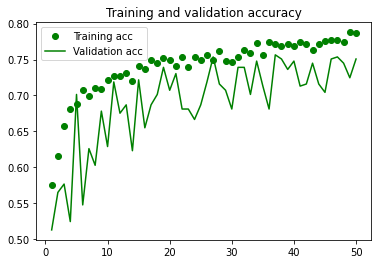

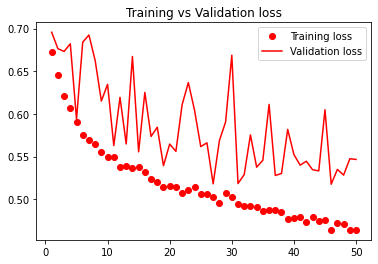

In [85]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training vs Validation loss')
plt.legend()

plt.show()

**We can observe that both graphs are Unstable**

Retraining the Model by Setting the weights of Embedding Layer as Trainable

In [86]:

units = 32

model = Sequential()
model.add(Embedding(num_events, embedding_dim))
model.add(LSTM(units))
model.add(Dense(1, activation='sigmoid'))

In [87]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

In [88]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_valid, y_valid))
model.save("trafficmodel-embedding-trainable.h5")

Epoch 1/50
44/44 [==============================] - 4s 47ms/step - loss: 0.6735 - acc: 0.6195 - val_loss: 0.6567 - val_acc: 0.6696
Epoch 2/50
44/44 [==============================] - 2s 37ms/step - loss: 0.6320 - acc: 0.6710 - val_loss: 0.6430 - val_acc: 0.6290
Epoch 3/50
44/44 [==============================] - 2s 37ms/step - loss: 0.6033 - acc: 0.6826 - val_loss: 0.6297 - val_acc: 0.6406
Epoch 4/50
44/44 [==============================] - 2s 38ms/step - loss: 0.5765 - acc: 0.7117 - val_loss: 0.5669 - val_acc: 0.7130
Epoch 5/50
44/44 [==============================] - 2s 38ms/step - loss: 0.5607 - acc: 0.7240 - val_loss: 0.6097 - val_acc: 0.5971
Epoch 6/50
44/44 [==============================] - 2s 37ms/step - loss: 0.5474 - acc: 0.7320 - val_loss: 0.6411 - val_acc: 0.5739
Epoch 7/50
44/44 [==============================] - 2s 38ms/step - loss: 0.5391 - acc: 0.7415 - val_loss: 0.6040 - val_acc: 0.6696
Epoch 8/50
44/44 [==============================] - 2s 38ms/step - loss: 0.5338 - a

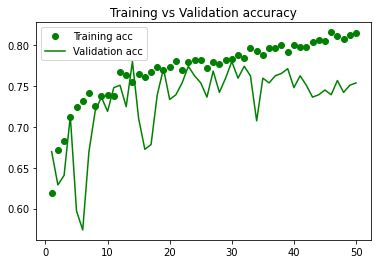

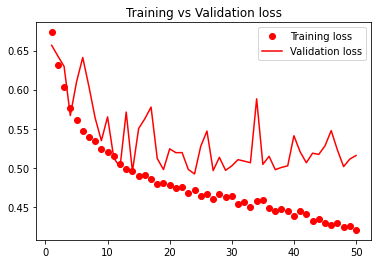

In [89]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training vs Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training vs Validation loss')
plt.legend()

plt.show()

We can see that the Model performed better than the Previous case
   

*   Fluctuation Of Validation Accuracy curve reduced
*   Validation accuracy increased to 75%

But,

When we look at the loss curve,We can observe that the training loss and validation loss curves went in different directions

This indicates that our model is **Over-fitting**



Retraining the previous model by adding **Dropouts**

In [104]:
units = 32

model = Sequential()
model.add(Embedding(num_events, embedding_dim))
model.add(LSTM(units, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [105]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

In [106]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_valid, y_valid))
model.save("Final-trafficmodel.h5")

Epoch 1/50
44/44 [==============================] - 7s 94ms/step - loss: 0.6787 - acc: 0.5795 - val_loss: 0.7169 - val_acc: 0.4899
Epoch 2/50
44/44 [==============================] - 4s 87ms/step - loss: 0.6536 - acc: 0.6245 - val_loss: 0.6672 - val_acc: 0.6000
Epoch 3/50
44/44 [==============================] - 4s 87ms/step - loss: 0.6258 - acc: 0.6587 - val_loss: 0.6419 - val_acc: 0.5507
Epoch 4/50
44/44 [==============================] - 4s 86ms/step - loss: 0.6015 - acc: 0.6768 - val_loss: 0.6303 - val_acc: 0.5420
Epoch 5/50
44/44 [==============================] - 4s 87ms/step - loss: 0.5925 - acc: 0.7008 - val_loss: 0.6752 - val_acc: 0.6029
Epoch 6/50
44/44 [==============================] - 4s 87ms/step - loss: 0.5862 - acc: 0.6885 - val_loss: 0.5525 - val_acc: 0.7159
Epoch 7/50
44/44 [==============================] - 4s 88ms/step - loss: 0.5744 - acc: 0.7131 - val_loss: 0.5635 - val_acc: 0.6986
Epoch 8/50
44/44 [==============================] - 4s 87ms/step - loss: 0.5621 - a

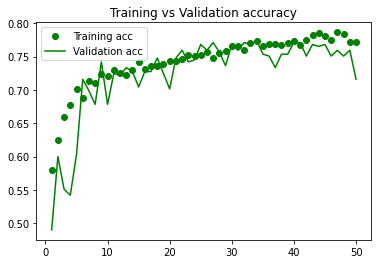

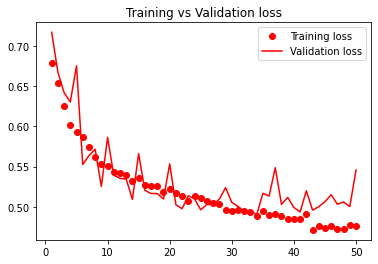

In [107]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training vs Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training vs Validation loss')
plt.legend()

plt.show()

We can observe that validation curve has become smoother indicating that over-fitting has been addressed